In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image
import os
import csv
from skimage import io
work_dir = "/kaggle/input/birds-22wi/birds"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

cpu


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.1+cpu
False


In [3]:
class TestImageDataSet(Dataset):

    def __init__(self, label_csv_file, root_dir, fileNames, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.true_label_csv = label_csv_file
        self.true_label_map = {}
        self.fileNameList = fileNames
        self.root_dir = root_dir
        self.transform = transform
#         self.parseLabelsToDict()
        
    def parseLabelsToDict(self):
        with open(self.true_label_csv, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                path = row["path"]
                classes = row["class"]
                self.true_label_map[path] = classes
            csvfile.close()
            
    def __len__(self):
        return len(self.fileNameList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.fileNameList[idx])
        image = Image.open(img_name).convert('RGB')
        
        
        item = [image, self.fileNameList[idx]]
        if self.transform:
            item[0] = self.transform(item[0])
        return item[0], item[1]
    
class TrainImageDataSet(Dataset):

    def __init__(self, label_csv_file, root_dir, fileNames, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.true_label_csv = label_csv_file
        self.true_label_map = {}
        self.fileNameList = fileNames
        self.root_dir = root_dir
        self.transform = transform
        self.parseLabelsToDict()
        
    def parseLabelsToDict(self):
        with open(self.true_label_csv, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                path = row["path"]
                classes = row["class"]
                self.true_label_map[path] = int(classes)
            csvfile.close()
            
    def __len__(self):
        return len(self.fileNameList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.fileNameList[idx])
        image = Image.open(img_name).convert('RGB')
        
        imageName = self.fileNameList[idx].split("/")[-1]
        item = [image, self.true_label_map[imageName]]
        if self.transform:
            item[0] = self.transform(item[0])
        return item[0], torch.tensor(item[1])

In [4]:
def get_birds_data():
    # Data augmentation transformations. Not for Testing!
    transform_train = transforms.Compose([
        transforms.Resize(64), # Takes images smaller than 64 and enlarges them
        transforms.RandomCrop(64, padding=4, padding_mode='edge'), # Take 64x64 crops from 72x72 padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
    ])

    trainFolderNames = os.listdir("/kaggle/input/birds-22wi/birds/train")
    trainFileNames = []
    for name in trainFolderNames:
        imageNames = (os.listdir("/kaggle/input/birds-22wi/birds/train/" + name))
        trainFileNames += ["/kaggle/input/birds-22wi/birds/train/" + name +"/"+ imageName for imageName in imageNames]
    trainset = TrainImageDataSet(label_csv_file="/kaggle/input/birds-22wi/birds/labels.csv", 
                               root_dir='/kaggle/input/birds-22wi/birds/train', fileNames=trainFileNames, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testFileNames = os.listdir("/kaggle/input/birds-22wi/birds/test/0")
    testset = TestImageDataSet(label_csv_file="/kaggle/input/birds-22wi/birds/labels.csv", 
                               root_dir='/kaggle/input/birds-22wi/birds/test/0', fileNames=testFileNames, transform=transform_test)
#     testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds-22wi/birds/test/', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=False)
    return {'train': trainloader, 'test': testloader}

data = get_birds_data()

8
torch.Size([8, 3, 64, 64])


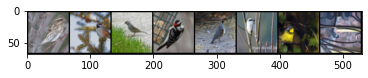

Labels:tensor(355) tensor(214) tensor(118) tensor(409) tensor(490) tensor(303) tensor(483) tensor(403)
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [5]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(len(images))
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

In [6]:
#WITHOUT BIAS
"""
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 555)

    def forward(self, x):
        # Input 64x64x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 8x8x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 4x4x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 2x2x256

        # Global average pooling across each channel (Input could be 2x2x256, 4x4x256, 7x3x256, output would always be 256 length vector)
        x = F.adaptive_avg_pool2d(x, 1)                                            # 1x1x256
        x = torch.flatten(x, 1)                                                    # vector 256
        
        x = self.fc1(x)
        return x
"""

'\nclass ConvBNNet(nn.Module):\n    def __init__(self):\n        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html\n        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)\n        self.bn1 = nn.BatchNorm2d(16)\n\n        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)\n        self.bn2 = nn.BatchNorm2d(32)\n\n        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)\n        self.bn3 = nn.BatchNorm2d(64)\n\n        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)\n        self.bn4 = nn.BatchNorm2d(128)\n\n        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)\n        self.bn5 = nn.BatchNorm2d(256)\n\n        self.fc1 = nn.Linear(256, 555)\n\n    def forward(self, x):\n        # Input 64x64x3\n\n        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16\n        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32\n        x 

In [7]:
"""
# WITH BIAS VERSION
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 555)

    def forward(self, x):
        # Input 64x64x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 8x8x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 4x4x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 2x2x256

        # Global average pooling across each channel (Input could be 2x2x256, 4x4x256, 7x3x256, output would always be 256 length vector)
        x = F.adaptive_avg_pool2d(x, 1)                                            # 1x1x256
        x = torch.flatten(x, 1)                                                    # vector 256
        
        x = self.fc1(x)
        return x
"""

'\n# WITH BIAS VERSION\nclass ConvBNNet(nn.Module):\n    def __init__(self):\n        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html\n        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)\n        self.bn1 = nn.BatchNorm2d(16)\n\n        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)\n        self.bn2 = nn.BatchNorm2d(32)\n\n        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)\n        self.bn3 = nn.BatchNorm2d(64)\n\n        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)\n        self.bn4 = nn.BatchNorm2d(128)\n\n        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)\n        self.bn5 = nn.BatchNorm2d(256)\n\n        self.fc1 = nn.Linear(256, 555)\n\n    def forward(self, x):\n        # Input 64x64x3\n\n        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16\n        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32\n        x = F.max_pool2d(F.relu(self.bn3(self.con

In [8]:
# WITHOUT BIAS VERSION & larger vector
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(2*2*256, 555)

    def forward(self, x):
        # Input 64x64x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 8x8x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 4x4x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 2x2x256

        # Global average pooling across each channel (Input could be 2x2x256, 4x4x256, 7x3x256, output would always be 256 length vector)
        x = torch.flatten(x, 1)                                                    # vector 2x2x256
        
        x = self.fc1(x)
        return x

In [9]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)


    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
            
    return losses

def evaluate(net, dataloader):
    net.to(device)
    net.eval()
    count = 1
    df = pd.DataFrame(columns=['path', "class"])
    with torch.no_grad():
        for batch in dataloader:
            print("batch:", count)
            count += 1
            images = batch[0].to(device)
            names = batch[1]
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            for i in range(len(predicted)):
                df = df.append({"path": "test/" + names[i], "class" : predicted[i].item()}, ignore_index=True)
            
    return df
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [10]:
final_net = ConvBNNet()

#final_losses =  train(final_net, data['train'], epochs=1, lr=.1  , decay=.0005)

#Real Training
final_losses =  train(final_net, data['train'], epochs=15, lr=.1  , decay=.0005)
final_losses += train(final_net, data['train'], epochs=15, lr=.01 , decay=.0005)
final_losses += train(final_net, data['train'], epochs=5, lr=.001, decay=.0005)
final_losses += train(final_net, data['train'], epochs=5, lr=.0001, decay=.0005)


[0,    10] loss: 6.894
[0,    20] loss: 6.796
[0,    30] loss: 6.623
[0,    40] loss: 6.530
[0,    50] loss: 6.399
[0,    60] loss: 6.273
[0,    70] loss: 6.247
[0,    80] loss: 6.226
[0,    90] loss: 6.192
[0,   100] loss: 6.131
[0,   110] loss: 6.148
[0,   120] loss: 6.127
[0,   130] loss: 6.121
[0,   140] loss: 6.070
[0,   150] loss: 6.046
[0,   160] loss: 6.025
[0,   170] loss: 5.989
[0,   180] loss: 6.027
[0,   190] loss: 6.048
[0,   200] loss: 5.986
[0,   210] loss: 5.971
[0,   220] loss: 5.929
[0,   230] loss: 5.966
[0,   240] loss: 5.921
[0,   250] loss: 5.916
[0,   260] loss: 5.944
[0,   270] loss: 5.852
[0,   280] loss: 5.904
[0,   290] loss: 5.890
[0,   300] loss: 5.866
[1,    10] loss: 5.819
[1,    20] loss: 5.812
[1,    30] loss: 5.789
[1,    40] loss: 5.774
[1,    50] loss: 5.781
[1,    60] loss: 5.753
[1,    70] loss: 5.782
[1,    80] loss: 5.762
[1,    90] loss: 5.797
[1,   100] loss: 5.730
[1,   110] loss: 5.683
[1,   120] loss: 5.634
[1,   130] loss: 5.679
[1,   140] 

In [11]:
#net = Darknet64()
# losses = train(net, data['train'], epochs=15, schedule={0:.1, 5:.01, 15:.001})

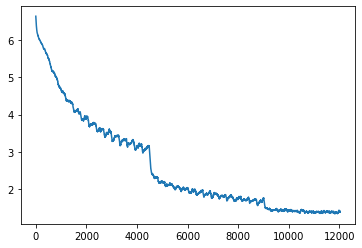

In [12]:
plt.plot(smooth(final_losses,50))


In [13]:
# print("Testing  accuracy: %f" % accuracy(net, data['test']))
result = evaluate(final_net, data["test"])
print(result)  
# total = 0
# correct = 0
# with torch.no_grad():
#     for i, batch in enumerate(data["train"], 0):
#         images, labels = batch[0].to(device), batch[1].to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         print(i)


batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
                                           path class
0     test/6378ee1e3d2b48d287bebebda32c8268.jpg   534
1     test/a14a6bbd400d4506875967db56005090.jpg   270
2     test/a6a2cc77b4d54f93b2e92aa7a1a5e7d8.jpg    62
3  

In [14]:
result.to_csv("output.csv", index = False)

In [15]:
len(result[result["class"] != 246])

9981